In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[]


In [2]:
RPN_network = tf.keras.models.load_model('best.h5')
backbone_encoder = tf.keras.models.load_model('base_classifier.h5')
classifier_network = tf.keras.models.load_model('classifier.h5')

In [3]:
categories = """None
Hardhat
NO-Hardhat
NO-Safety Vest
Person
Safety Vest
"""
categories = categories.split('\n')[:-1] 

In [4]:
categories = {i  : categories[i] for i in range(len(categories))}

In [229]:
categories

{0: 'None',
 1: 'Hardhat',
 2: 'NO-Hardhat',
 3: 'NO-Safety Vest',
 4: 'Person',
 5: 'Safety Vest'}

In [5]:
colors = tf.concat([[[1,1,1]],tf.random.uniform([90, 3], 0, 1, dtype = tf.float32)], axis = 0) + 0.5

def draw_box(image, box, color = (255, 0, 0), image_size = 244):
    image = cv2.rectangle(image, 
                          (int(tf.clip_by_value(box[0], 0, image_size)), int(tf.clip_by_value(box[1], 0, image_size))), 
                          (int(tf.clip_by_value(box[2], 0, image_size)), int(tf.clip_by_value(box[3], 0, image_size))),
                          color, 1)
    return image

def draw_boxes(image, boxes, classes, probs, ignore_zero_class = False, image_size = 244):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    for i in range(boxes.shape[0]):
        r = float(colors[classes[i]].numpy()[0])
        g = float(colors[classes[i]].numpy()[1])
        b = float(colors[classes[i]].numpy()[2])
        if classes[i] > 0 or not ignore_zero_class:
            image = draw_box(image, boxes[i], color = (r, g, b), image_size = image_size)
            org = ((int(boxes[i][0]),  int(boxes[i][1])-10))
            text = categories[int(classes[i])] + " " + str(float(probs[i]*100))[:4]
            big_image = cv2.putText(image, text, org, font, fontScale, (r, g, b), thickness, cv2.LINE_AA)
    return image

@tf.function
def IoU(boxA, boxB):
    boxes = tf.concat([tf.expand_dims(boxA, axis = 0), tf.expand_dims(boxB, axis = 0)], axis = 0)
    A = tf.reduce_max(boxes, axis = 0)
    B = tf.reduce_min(boxes, axis = 0)
    xA = A[:, 0]
    yA = A[:, 1]
    xB = B[:, 2]
    yB = B[:, 3]

    interW = tf.nn.relu(xB - xA + 1)
    interH = tf.nn.relu(yB - yA + 1)

    interArea = interW * interH
    boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
    boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

    iou = interArea / tf.cast(boxAArea + boxBArea - interArea, dtype=tf.float32)
    return iou

@tf.function
def create_position_tensor(n):
    x_positions = tf.linspace(0.0, float(n - 1), n)
    y_positions = tf.linspace(0.0, float(n - 1), n)
    x_grid, y_grid = tf.meshgrid(x_positions, y_positions)
    position_tensor = tf.stack([x_grid, y_grid, x_grid, y_grid], axis=-1)
    return position_tensor

def non_maximum_supression(boxes, scores, th = 0.2):
    num_boxes = boxes.shape[0]
    axis_A = tf.repeat(tf.expand_dims(boxes, axis = 0), num_boxes, axis = 0)
    axis_B = tf.tile(tf.expand_dims(boxes, axis=1), multiples=[1, num_boxes, 1])
    axis_A = tf.reshape(axis_A, [-1, 4])
    axis_B = tf.reshape(axis_B, [-1, 4])
    cross_iou = IoU(axis_A, axis_B)
    resulted_boxes = []
    resulted_scores = []
    #выгрузка с видеокарты для циклического опроса
    cross_iou = cross_iou.numpy()
    scores = scores.numpy()
    for i in range(num_boxes):
        discard = False
        for j in range(num_boxes):
            if (cross_iou[i * num_boxes + j] > th):
                if(scores[j, 1] > scores[i, 1]):
                    discard = True
                    break
        if not discard:
            resulted_boxes.append(boxes[i])
            resulted_scores.append(scores[i])
    resulted_boxes = tf.cast(resulted_boxes, dtype = tf.float32)
    resulted_scores = tf.cast(resulted_scores, dtype = tf.float32)
    return (resulted_boxes, resulted_scores)


def postprocess_proposals(raw_boxes, raw_scores, th = 0.5):
    delta = 17
    shift = create_position_tensor(14)
    raw_boxes += shift
    raw_boxes *= delta
    raw_boxes = tf.clip_by_value(raw_boxes, 0, 244)
    raw_boxes = tf.reshape(raw_boxes, [-1, 4])
    raw_scores = tf.reshape(raw_scores, [-1, 2])
    boxes, scores = non_maximum_supression(raw_boxes, raw_scores)
    top_boxes = []
    top_scores = []
    for i in range(boxes.shape[0]):
        if scores[i, 1] > th:
            top_boxes.append(boxes[i])
            top_scores.append(scores[i, 1])
    top_boxes = tf.stack(top_boxes)
    top_scores = tf.stack(top_scores)
    return (top_boxes, top_scores)

def fill(shape, value):
    for ax in shape:
        value = tf.repeat(tf.expand_dims(value, axis = 1), ax, axis = 1)
    return value 

def roi_pool(boxes, feature_map, embedding_size = 3, image_size = 224, pool_size = 3):

    # Нормализуем координаты боксов к [0,1]
    boxes_normalized = boxes / image_size
    
    # Создаем индексы для каждого бокса (все относятся к 0-му изображению в батче)
    box_indices = tf.zeros([tf.shape(boxes)[0]], dtype=tf.int32)
    
    # Добавляем размерность батча к feature map
    batched_feature_map = tf.expand_dims(feature_map, axis=0)
    
    # Применяем операцию
    pooled_regions = tf.image.crop_and_resize(
        batched_feature_map,
        boxes_normalized,
        box_indices,
        [pool_size, pool_size]
    )
    
    return pooled_regions

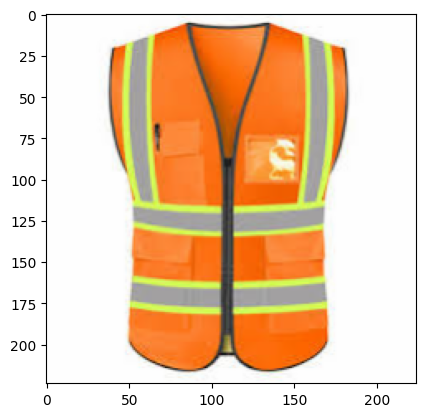

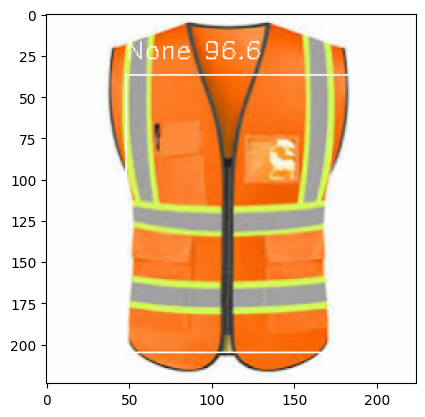

Safety Vest


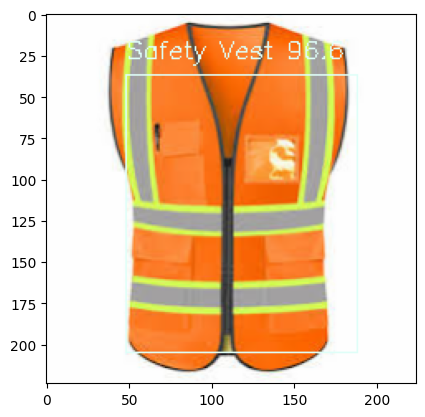

In [6]:
path = r'.cache\roboflow\PPE.v14i.yolokeras\train\test1.jpg'

image = cv2.imread(path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image = tf.cast(image, dtype = tf.float32) / 128 - 1
image = tf.image.resize(image, (224, 224))
test_image = ((image+1)/2).numpy()
plt.imshow(test_image)
plt.show()

raw_scores, raw_boxes = RPN_network(tf.expand_dims(image, axis = 0))
boxes, scores = postprocess_proposals(raw_boxes, raw_scores)
classes = tf.zeros([boxes.shape[0]], dtype = tf.int32)
test_image = draw_boxes(test_image, boxes, classes, scores)
plt.imshow(test_image)
plt.show()

feature_map = backbone_encoder(tf.expand_dims(image, axis = 0))
rois = roi_pool(boxes, feature_map[0])
probs = classifier_network(rois)
classes = tf.argmax(probs, axis = 1)
test_image = ((image+1)/2).numpy()
test_image = draw_boxes(test_image, boxes, classes, scores)
for item in classes:
    print(categories[int(item)])
plt.imshow(test_image)
plt.show()

In [7]:
def detect(frame, class_names=None):
    # Конвертация и ресайз
    h, w = frame.shape[:2]
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, (224, 224))
    
    # Нормализация
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    
    # Детекция
    raw_scores, raw_boxes = RPN_network(tf.expand_dims(image, axis=0))
    boxes, scores = postprocess_proposals(raw_boxes, raw_scores, th=0.7)
    
    # Подготовка вывода
    output = frame.copy()
    
    if boxes.shape[0] > 0:
        # Масштабирование bbox
        scale_y, scale_x = h / 224, w / 224
        boxes = boxes * [scale_x, scale_y, scale_x, scale_y]
        boxes = np.clip(boxes, 0, [w-1, h-1, w-1, h-1])
        
        # Получение классов
        feature_map = backbone_encoder(tf.expand_dims(image, axis=0))
        rois = roi_pool(boxes, feature_map[0])
        probs = classifier_network(rois)
        classes = tf.argmax(probs, axis=1).numpy()

        
        # Параметры отрисовки
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        thickness = 2
        text_color = (255, 255, 255)  # Белый
        bg_color = (0, 0, 255)  # Красный
        
        for box, score, cls in zip(boxes, scores, classes):
            # if cls == 0:
            #     continue
            x1, y1, x2, y2 = map(int, box)
            
            # Рисуем прямоугольник
            cv2.rectangle(output, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Формируем текст
            label = f"{class_names[cls] if class_names else cls}: {score:.2f}"
            
            # Рассчитываем размер текста
            (text_width, text_height), _ = cv2.getTextSize(
                label, font, font_scale, thickness)
            
            # Позиция текста (гарантированно внутри кадра)
            text_x = x1
            text_y = y1 - 5 if y1 - 5 > text_height else y1 + text_height + 5
            
            # Рисуем подложку
            cv2.rectangle(output,
                        (text_x, text_y - text_height - 5),
                        (text_x + text_width, text_y + 5),
                        bg_color, -1)
            
            # Рисуем текст
            cv2.putText(output, label, 
                       (text_x, text_y), 
                       font, font_scale, 
                       text_color, thickness, 
                       cv2.LINE_AA)
    
    return output

In [8]:
cap = cv2.VideoCapture(r'.cache\roboflow\PPE.v14i.yolokeras\train\test4.mov')
 

if (cap.isOpened()== False): 
    print("Error opening video stream or file")
    
frame_width = 224*5
frame_height = 224*5
   
size = (frame_width, frame_height)
print(size)

result = cv2.VideoWriter('filename.avi', cv2.VideoWriter_fourcc(*'MJPG'),10, size)
while(cap.isOpened()):
    if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    ret, frame = cap.read()
    if ret == True:
        frame = detect(frame, categories)
        cv2.imshow('Frame', frame)
        result.write(frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break
result.release()
cap.release()
cv2.destroyAllWindows()

(1120, 1120)


KeyboardInterrupt: 

In [11]:
1 + 1

2

In [234]:


def webcam_processing(class_names=None, camera_index=0, output_file=None):
   
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print("Ошибка: не удалось открыть камеру!")
        return
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    if output_file:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_file, fourcc, 20.0, (frame_width, frame_height))
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Ошибка получения кадра!")
                break
            
            frame = cv2.flip(frame, 1)
            
            processed_frame = detect(frame, class_names)
            
            cv2.imshow('Webcam Detection', processed_frame)
            
            if output_file:
                out.write(processed_frame)
            
            key = cv2.waitKey(1)
            if key in (27, ord('q')):
                break
                
    finally:
        cap.release()
        if output_file:
            out.release()
        cv2.destroyAllWindows()
        print("Обработка завершена")

    
webcam_processing(
    class_names=categories,
    camera_index=0,  
    output_file='output.avi' 
)

Обработка завершена


In [14]:
import tkinter as tk
from tkinter import ttk, filedialog
import cv2
import numpy as np
from PIL import Image, ImageTk
import tensorflow as tf

class WebcamApp:
    def __init__(self, window, window_title):
        self.window = window
        self.window.title(window_title)
        
        # Настройка переменных
        self.video_source = 0  # Веб-камера по умолчанию
        self.cap = None
        self.recording = False
        self.out = None
        self.class_names = {
            0: 'None',
            1: 'Hardhat',
            2: 'NO-Hardhat',
            3: 'NO-Safety Vest',
            4: 'Person',
            5: 'Safety Vest'
        }
        
        # Создание интерфейса
        self.create_widgets()
        
        # Обновление кадров
        self.delay = 15
        self.update()
        
        self.window.mainloop()
    
    def create_widgets(self):
        # Главный контейнер
        main_container = ttk.Frame(self.window)
        main_container.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Фрейм для видео с центрированием
        video_container = ttk.Frame(main_container)
        video_container.pack(expand=True)
        
        # Canvas для отображения видео
        self.canvas = tk.Canvas(video_container, width=800, height=600)
        self.canvas.pack()
        
        # Фрейм управления (внизу окна)
        control_frame = ttk.Frame(main_container)
        control_frame.pack(fill=tk.X, pady=5)
        
        # Кнопки управления
        self.btn_start = ttk.Button(control_frame, text="Старт", command=self.start_camera)
        self.btn_start.pack(side=tk.LEFT, padx=5)
        
        self.btn_stop = ttk.Button(control_frame, text="Стоп", command=self.stop_camera, state=tk.DISABLED)
        self.btn_stop.pack(side=tk.LEFT, padx=5)
        
        self.btn_snapshot = ttk.Button(control_frame, text="Снимок", command=self.take_snapshot, state=tk.DISABLED)
        self.btn_snapshot.pack(side=tk.LEFT, padx=5)
        
        self.btn_record = ttk.Button(control_frame, text="Запись", command=self.toggle_recording, state=tk.DISABLED)
        self.btn_record.pack(side=tk.LEFT, padx=5)
        
        # Выбор камеры
        ttk.Label(control_frame, text="Камера:").pack(side=tk.LEFT, padx=5)
        self.camera_selector = ttk.Combobox(control_frame, values=[0, 1, 2], width=3)
        self.camera_selector.pack(side=tk.LEFT, padx=5)
        self.camera_selector.current(0)
        
        # Информационная панель
        info_frame = ttk.Frame(control_frame)
        info_frame.pack(side=tk.RIGHT, padx=5)
        
        self.lbl_status = ttk.Label(info_frame, text="Камера не активирована")
        self.lbl_status.pack(side=tk.LEFT)
        
        self.lbl_fps = ttk.Label(info_frame, text="FPS: 0")
        self.lbl_fps.pack(side=tk.LEFT, padx=10)
    
    def start_camera(self):
        # Остановка предыдущего источника
        if self.cap is not None:
            self.cap.release()
        
        # Инициализация новой камеры
        self.video_source = int(self.camera_selector.get())
        self.cap = cv2.VideoCapture(self.video_source)
        
        # Настройка кнопок
        self.btn_start.config(state=tk.DISABLED)
        self.btn_stop.config(state=tk.NORMAL)
        self.btn_snapshot.config(state=tk.NORMAL)
        self.btn_record.config(state=tk.NORMAL)
        
        self.lbl_status.config(text=f"Камера {self.video_source} активирована")
    
    def stop_camera(self):
        if self.cap is not None:
            self.cap.release()
            self.cap = None
        
        if self.recording:
            self.toggle_recording()
        
        # Настройка кнопок
        self.btn_start.config(state=tk.NORMAL)
        self.btn_stop.config(state=tk.DISABLED)
        self.btn_snapshot.config(state=tk.DISABLED)
        self.btn_record.config(state=tk.DISABLED)
        
        self.lbl_status.config(text="Камера не активирована")
        
        # Очистка canvas
        self.canvas.delete("all")
    
    def take_snapshot(self):
        if self.cap is not None and hasattr(self, 'last_frame'):
            filename = filedialog.asksaveasfilename(
                defaultextension=".jpg",
                filetypes=[("JPEG files", "*.jpg"), ("All files", "*.*")]
            )
            if filename:
                cv2.imwrite(filename, cv2.cvtColor(self.last_frame, cv2.COLOR_RGB2BGR))
                self.lbl_status.config(text=f"Снимок сохранен: {filename}")
    
    def toggle_recording(self):
        if not self.recording:
            # Начало записи
            filename = filedialog.asksaveasfilename(
                defaultextension=".avi",
                filetypes=[("AVI files", "*.avi"), ("All files", "*.*")]
            )
            if filename:
                frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                self.out = cv2.VideoWriter(
                    filename,
                    cv2.VideoWriter_fourcc(*'MJPG'),
                    20.0,
                    (frame_width, frame_height)
                )
                self.recording = True
                self.btn_record.config(text="Стоп запись")
                self.lbl_status.config(text=f"Идет запись: {filename}")
        else:
            # Остановка записи
            if self.out is not None:
                self.out.release()
                self.out = None
            self.recording = False
            self.btn_record.config(text="Запись")
            self.lbl_status.config(text="Запись остановлена")
    
    def update(self):
        if self.cap is not None:
            ret, frame = self.cap.read()
            if ret:
                # Обработка кадра
                processed_frame = detect(frame, self.class_names)
                self.last_frame = processed_frame
                
                # Запись видео если включена
                if self.recording and self.out is not None:
                    self.out.write(cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
                
                # Конвертация для Tkinter
                img = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)
                img = Image.fromarray(img)
                img = ImageTk.PhotoImage(image=img)
                
                # Обновление изображения с центрированием
                self.canvas.delete("all")
                canvas_width = self.canvas.winfo_width()
                canvas_height = self.canvas.winfo_height()
                
                # Вычисление координат для центрирования
                x = (canvas_width - img.width()) // 2
                y = (canvas_height - img.height()) // 2
                
                # Отображение изображения по центру
                self.canvas.create_image(x, y, anchor=tk.NW, image=img)
                self.canvas.image = img
        
        self.window.after(self.delay, self.update)


# Запуск приложения
if __name__ == "__main__":
    root = tk.Tk()
    app = WebcamApp(root, "Детекция объектов с веб-камеры")